# 음성 인식 분류기

## 1. 데이터 준비하기

### (1) 데이터 다운로드

1차원 형태의 wav파일을 다운로드받고 확인을 해본다.

In [1]:
# 데이터 처리와 분류
import numpy as np
import os

data_path = os.getenv("HOME")+'/workplace/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)


import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

del data

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
rand num :  10646
Wave data shape :  (8000,)
label :  ['off']


### (2) 데이터 전처리

1차원 형태의 wav파일을 2차원 형태의 spectrogram으로 변환시킨다.  
**Short Time Fourier Transform**(*STFT*)은 Fourier Transform(FFT)을 짧게 여러번 나눠서 실행해주는 방법으로 어느 시간대에 주파수가 변하는지 모르는 FFT의 단점을 보완하기 위해 사용된다.
librosa.stft함수를 사용하는데 리스트를 전부 변환해주는 줄로 알고있다가 데이터 변환이 안되서 고생했다.

Waveform shape :  (50620, 8000)
Spectrogram shape :  (50620, 130, 126)


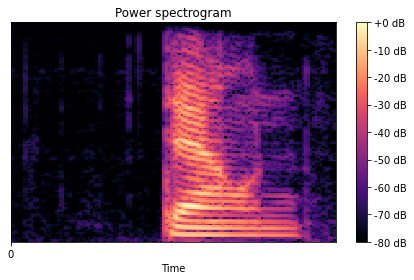

In [2]:
# Short Time Fourier Transform
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

spec_data = []
for wav in speech_data["wav_vals"]:
    temp = wav2spec(wav)
    spec_data.append(temp)

spec_data = np.array(spec_data)

print("Waveform shape : ",speech_data["wav_vals"].shape)
print("Spectrogram shape : ",spec_data.shape)  


import librosa.display
import matplotlib.pyplot as plt

librosa.display.specshow(librosa.amplitude_to_db(spec_data[0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

### (3)데이터셋 구성

데이터 전처리가 끝났으니 train데이터셋과 test데이터셋으로 나눈다.

In [3]:
# Train/Test 데이터셋 구성
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

del speech_data


# 데이터 분리
from sklearn.model_selection import train_test_split

sr = 8000
train_spec, test_spec, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_spec)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}
[[[1.25909925e-01 4.32241350e-01 6.61550999e-01 ... 1.04169536e+00
   8.93304110e-01 6.93469286e-01]
  [1.58173576e-01 4.21954274e-01 4.65274990e-01 ... 6.35072470e-01
   5.07827878e-01 2.34883904e-01]
  [3.38650733e-01 1.69605881e-01 1.48226663e-01 ... 1.63315445e-01
   7.78233185e-02 1.65230140e-01]
  ...
  [1.44749752e-03 7.21454271e-04 1.07708998e-04 ... 3.21766202e-05
   1.72595566e-04 4.11611691e-04]
  [1.49802328e-03 7.70733866e-04 2.77272557e-05 ... 4.46039339e-05
   2.31826576e-04 4.08781751e-04]
  [1.53122959e-03 7.78423855e-04 1.08432450e-05 ... 1.02130325e-05
   2.06578698e-04 4.21542878e-04]]

 [[1.55238928e-02 7.82471057e-03 3.12480639e-04 ... 2.78560445e-04
   4.16126754e-03 1.06949732e-02]
  [1.83265489e-02 8.05349741e-03 

## 2. 모델 학습시키기

conv2D와 skip-connection 모델을 사용할 예정이다.
메모리를 많이 잡아먹기 때문에 batch_size는 건드리지 않고 epochs는 여러번 돌려본 결과 효율이 좋아보이는 3으로 설정했다.

In [4]:
# 하이퍼파라미터 세팅
batch_size = 32
max_epochs = 3

# the save point
checkpoint_dir = os.getenv('HOME')+'/workplace/aiffel/speech_recognition/models/spec'

checkpoint_dir

'/home/aiffel-dj13/workplace/aiffel/speech_recognition/models/spec'

라벨링을 해주는 함수를 작성 후 데이터셋을 나눠주고 메모리 관리를 위해 spec_data를 삭제했다.

In [5]:
# 데이터 세팅
def one_hot_label(spec, label):
    label = tf.one_hot(label, depth=12)
    return spec, label

import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

del spec_data

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


아래는 conv2D를 활용한 모델이다. 메모리때문에 도저히 두 모델을 동시에 돌릴수가 없어서 주석으로 처리했다.
batchnormalization, dense layer 등을 사용하였다.

이 부분에서는 input data의 shape을 이해하는데 어려움을 겪었다.

In [6]:
'''
# spec classificationo 모델 구현
# 모델
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()
'''

"\n# spec classificationo 모델 구현\n# 모델\nfrom tensorflow.keras import layers\n\ninput_tensor = layers.Input(shape=(130, 126, 1))\n\nx = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)\nx = layers.Conv2D(32, 9, padding='same', activation='relu')(x)\nx = layers.MaxPool2D()(x)\n\nx = layers.Conv2D(64, 9, padding='same', activation='relu')(x)\nx = layers.Conv2D(64, 9, padding='same', activation='relu')(x)\nx = layers.MaxPool2D()(x)\n\nx = layers.Conv2D(128, 9, padding='same', activation='relu')(x)\nx = layers.Conv2D(128, 9, padding='same', activation='relu')(x)\nx = layers.Conv2D(128, 9, padding='same', activation='relu')(x)\nx = layers.MaxPool2D()(x)\n\nx = layers.Conv2D(256, 9, padding='same', activation='relu')(x)\nx = layers.Conv2D(256, 9, padding='same', activation='relu')(x)\nx = layers.Conv2D(256, 9, padding='same', activation='relu')(x)\nx = layers.MaxPool2D()(x)\nx = layers.Dropout(0.3)(x)\n\nx = layers.Flatten()(x)\nx = layers.Dense(256)(x)\nx = layers.BatchNo

Adam을 사용하여 optimization을 한 이후 가중치를 저장하기 위해 callback함수를 사용했다.

In [7]:
'''
# loss
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

# training
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)     
'''                                                                                             

"\n# loss\noptimizer=tf.keras.optimizers.Adam(1e-4)\nmodel_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),\n             optimizer=optimizer,\n             metrics=['accuracy'])\n\n# training\ncp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,\n                                                 save_weights_only=True,\n                                                 monitor='val_loss',\n                                                 mode='auto',\n                                                 save_best_only=True,\n                                                 verbose=1)     \n"

In [8]:
'''
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
'''                    

'\n#30분 내외 소요 (메모리 사용량에 주의해 주세요.)\nhistory_spec = model_spec.fit(train_dataset, epochs=max_epochs,\n                    steps_per_epoch=len(train_spec) // batch_size,\n                    validation_data=test_dataset,\n                    validation_steps=len(test_spec) // batch_size,\n                    callbacks=[cp_callback]\n                    )\n'

결과물을 그래프로 나타내보았으며 이 그래프 기준으로 epochs값을 결정하였다.

In [9]:
'''
# 학습 결과 plot
import matplotlib.pyplot as plt

acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
'''

"\n# 학습 결과 plot\nimport matplotlib.pyplot as plt\n\nacc = history_spec.history['accuracy']\nval_acc = history_spec.history['val_accuracy']\n\nloss=history_spec.history['loss']\nval_loss=history_spec.history['val_loss']\n\nepochs_range = range(len(acc))\n\nplt.figure(figsize=(8, 8))\nplt.subplot(1, 2, 1)\nplt.plot(epochs_range, acc, label='Training Accuracy')\nplt.plot(epochs_range, val_acc, label='Validation Accuracy')\nplt.legend(loc='lower right')\nplt.title('Training and Validation Accuracy')\n\nplt.subplot(1, 2, 2)\nplt.plot(epochs_range, loss, label='Training Loss')\nplt.plot(epochs_range, val_loss, label='Validation Loss')\nplt.legend(loc='upper right')\nplt.title('Training and Validation Loss')\nplt.show()\n"

In [10]:
'''
# Evaluation
model_spec.load_weights(checkpoint_dir)

results = model_spec.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
'''

'\n# Evaluation\nmodel_spec.load_weights(checkpoint_dir)\n\nresults = model_spec.evaluate(test_dataset)\n\n# loss\nprint("loss value: {:.3f}".format(results[0]))\n# accuracy\nprint("accuracy value: {:.4f}%".format(results[1]*100))\n'

## 3. 테스트하기

conv2D를 활용한 모델은 93%의 성능을 보여줬다.

In [11]:
'''
# 모델 test
# import IPython.display as ipd

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

# prediction
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

del model_spec
del history_spec 
'''

'\n# 모델 test\n# import IPython.display as ipd\n\ninv_label_value = {v: k for k, v in label_value.items()}\nbatch_index = np.random.choice(len(test_spec), size=1, replace=False)\n\nbatch_xs = test_spec[batch_index]\nbatch_ys = test_label[batch_index]\ny_pred_ = model_spec(batch_xs, training=False)\n\nprint("label : ", str(inv_label_value[batch_ys[0]]))\n\n# ipd.Audio(batch_xs.reshape(8000,), rate=8000)\n\n# prediction\nif np.argmax(y_pred_) == batch_ys[0]:\n    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + \'(Correct!)\')\nelse:\n    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + \'(Incorrect!)\')\n\ndel model_spec\ndel history_spec \n'

이후로는 skip-connection을 활용한 모델이다. 앞의 모델과 유사해서 구현하는데에는 큰 문제점이 없었다.

In [12]:

# skip-connection 모델
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 32) 2624        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 130, 126, 32) 82976       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

# the save point
checkpoint_dir = os.getenv('HOME')+'/workplace/aiffel/speech_recognition/models/spec_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [14]:
history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/3
1423/1423 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.7750
Epoch 00001: val_loss improved from inf to 0.22874, saving model to /home/aiffel-dj13/workplace/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 240s 169ms/step - loss: 0.6914 - accuracy: 0.7750 - val_loss: 0.2287 - val_accuracy: 0.9231
Epoch 2/3
1423/1423 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9361
Epoch 00002: val_loss improved from 0.22874 to 0.16142, saving model to /home/aiffel-dj13/workplace/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 241s 169ms/step - loss: 0.2004 - accuracy: 0.9361 - val_loss: 0.1614 - val_accuracy: 0.9476
Epoch 3/3
1423/1423 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9573
Epoch 00003: val_loss improved from 0.16142 to 0.16118, saving model to /home/aiffel-dj13/workplace/aiffel/speech_recognition/models/spec_skip
1423/1423 

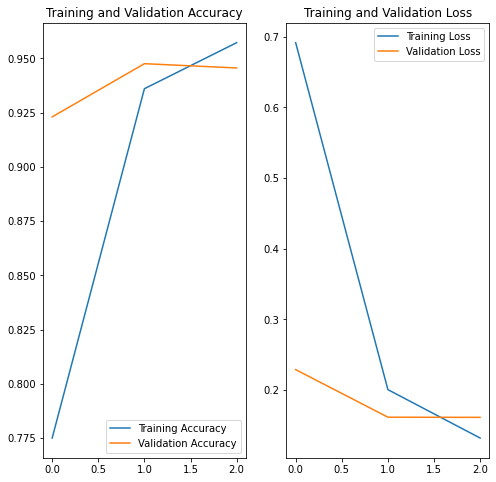

In [15]:
import matplotlib.pyplot as plt

acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# Evaluation 

model_spec_skip.load_weights(checkpoint_dir)
results = model_spec_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

159/159 [==============================] - 27s 171ms/step - loss: 0.1610 - accuracy: 0.9457
loss value: 0.161
accuracy value: 94.5674%
label :  yes
y_pred: yes(Correct!)


## 회고

이번 프로젝트는 예상외의 어려움이 많았다. 일단 직관적이었던 비전과 달리 음성데이터의 데이터 형태 변환을 이해하는데 많은 어려움이 있었던 프로젝트였다. 그 외에도 처음으로 메모리 부족 문제로 고생을 해보기도 했는데 두가지 사항에 대한 추가적인 공부가 필요할 것 같다.